In [1]:
!pip install medmnist
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=28b6c2654a0d0dec17611f9d0ce0774908feac607173501a1ef74b8b219315ad
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 2.9 MB/s eta 0:00:00


In [2]:
import medmnist
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [25]:
def train(model, loader, optimizer, convert_to_binary, epochs, device,pneumonia_flag):
    criterion_bce = nn.BCEWithLogitsLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            if (pneumonia_flag == 0):
              if convert_to_binary:
                  targets = (targets.sum(axis=1) > 0).float()  # Convert to binary
              loss = criterion_bce(outputs, targets.unsqueeze(1))
              avg_loss += loss.item()
              loss.backward()
              optimizer.step()
            elif(pneumonia_flag == 1):
              if convert_to_binary:
                  targets = targets.sum(dim=1, keepdim=True).float()  # Convert to binary

              # Ensure the output and target types match
              if targets.dtype != outputs.dtype:
                  targets = targets.type_as(outputs)

              loss = criterion_bce(outputs, targets)
              avg_loss += loss.item()
              loss.backward()
              optimizer.step()

        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch + 1, avg_loss))
    return model


def test(model, loader, device, convert_to_binary, pneumonia_flag):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, targets_batch in tqdm(loader):
            inputs, targets_batch = inputs.to(device), targets_batch.to(device)
            outputs = model(inputs)
            if(pneumonia_flag == 0):
              if convert_to_binary:
                  targets_batch = targets_batch.sum(dim=1, keepdim=True).float()

              preds.extend(outputs.cpu().numpy())
              targets.extend(targets_batch.cpu().numpy())
            elif(pneumonia_flag == 1):
              if convert_to_binary:
                  targets_batch = targets_batch.sum(dim=1, keepdim=True).float()

              preds.extend(outputs.cpu().numpy())
              targets.extend(targets_batch.cpu().numpy())
    preds = torch.sigmoid(torch.tensor(preds)).numpy()
    targets = torch.tensor(targets).numpy()

    # Calculate evaluation metrics
    accuracy = accuracy_score(targets, (preds > 0.5).astype(int))
    precision = precision_score(targets, (preds > 0.5).astype(int), average='weighted')
    recall = recall_score(targets, (preds > 0.5).astype(int), average='weighted')
    f1 = f1_score(targets, (preds > 0.5).astype(int), average='weighted')

    print('Accuracy: {:.4f}\tPrecision: {:.4f}\tRecall: {:.4f}\tF1 Score: {:.4f}'.format(
        accuracy, precision, recall, f1))

# Chest

In [4]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
#n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'])

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download) ##print it to know more info about it
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

100%|██████████| 82802576/82802576 [00:01<00:00, 58020879.50it/s]


Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [6]:
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, 1)
        )

        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)

        if self.extract_embeddings:
            return x  # Return the embeddings directly
        else:
            x = self.fc(x)
            return x

# Instantiate the Net
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)
model_chest.extract_embeddings = False

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=30, device=device, pneumonia_flag = 0)


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch: 1	Loss: 0.7222


100%|██████████| 5/5 [00:00<00:00, 18.57it/s]


Epoch: 2	Loss: 0.6679


100%|██████████| 5/5 [00:00<00:00, 31.94it/s]


Epoch: 3	Loss: 0.6017


100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Epoch: 4	Loss: 0.5539


100%|██████████| 5/5 [00:00<00:00, 22.48it/s]


Epoch: 5	Loss: 0.5191


100%|██████████| 5/5 [00:00<00:00, 24.88it/s]


Epoch: 6	Loss: 0.4816


100%|██████████| 5/5 [00:00<00:00, 31.26it/s]


Epoch: 7	Loss: 0.4462


100%|██████████| 5/5 [00:00<00:00, 26.52it/s]


Epoch: 8	Loss: 0.4072


100%|██████████| 5/5 [00:00<00:00, 32.22it/s]


Epoch: 9	Loss: 0.3878


100%|██████████| 5/5 [00:00<00:00, 42.74it/s]


Epoch: 10	Loss: 0.3491


100%|██████████| 5/5 [00:00<00:00, 36.59it/s]


Epoch: 11	Loss: 0.3244


100%|██████████| 5/5 [00:00<00:00, 33.51it/s]


Epoch: 12	Loss: 0.3075


100%|██████████| 5/5 [00:00<00:00, 24.78it/s]


Epoch: 13	Loss: 0.2823


100%|██████████| 5/5 [00:00<00:00, 28.16it/s]


Epoch: 14	Loss: 0.2621


100%|██████████| 5/5 [00:00<00:00, 37.16it/s]


Epoch: 15	Loss: 0.2391


100%|██████████| 5/5 [00:00<00:00, 27.62it/s]


Epoch: 16	Loss: 0.2221


100%|██████████| 5/5 [00:00<00:00, 28.61it/s]


Epoch: 17	Loss: 0.2167


100%|██████████| 5/5 [00:00<00:00, 28.93it/s]


Epoch: 18	Loss: 0.1933


100%|██████████| 5/5 [00:00<00:00, 29.85it/s]


Epoch: 19	Loss: 0.1751


100%|██████████| 5/5 [00:00<00:00, 19.97it/s]


Epoch: 20	Loss: 0.1614


100%|██████████| 5/5 [00:00<00:00, 34.35it/s]


Epoch: 21	Loss: 0.1498


100%|██████████| 5/5 [00:00<00:00, 17.64it/s]


Epoch: 22	Loss: 0.1382


100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Epoch: 23	Loss: 0.1277


100%|██████████| 5/5 [00:00<00:00, 22.10it/s]


Epoch: 24	Loss: 0.1232


100%|██████████| 5/5 [00:00<00:00, 25.11it/s]


Epoch: 25	Loss: 0.1114


100%|██████████| 5/5 [00:00<00:00, 41.22it/s]


Epoch: 26	Loss: 0.1029


100%|██████████| 5/5 [00:00<00:00, 34.12it/s]


Epoch: 27	Loss: 0.0972


100%|██████████| 5/5 [00:00<00:00, 35.62it/s]


Epoch: 28	Loss: 0.0877


100%|██████████| 5/5 [00:00<00:00, 34.62it/s]


Epoch: 29	Loss: 0.0829


100%|██████████| 5/5 [00:00<00:00, 30.20it/s]

Epoch: 30	Loss: 0.0760


Positive rate:  0.44666666666666666


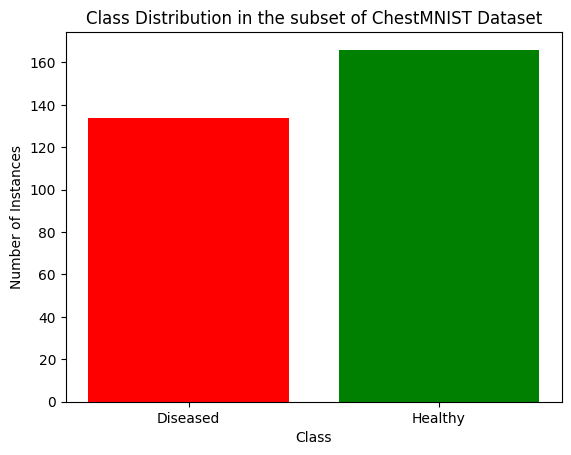

In [7]:
# Examine the data distribution of the binary classification task. Is accuracy a good metric?

#This is for the 300 example only
all_labels = train_dataset_chest.labels
binary_targets = (all_labels.sum(axis=1) > 0).astype(float)

num_positive = binary_targets.sum()

total_instances = binary_targets.size

positive_rate = num_positive / total_instances

print("Positive rate: ", positive_rate)


# Count the instances of each class
num_diseased = num_positive
num_healthy = total_instances - num_positive

# Class distribution
classes = ['Diseased', 'Healthy']
counts = [num_diseased, num_healthy]

# Create bar chart
plt.bar(classes, counts, color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in the subset of ChestMNIST Dataset')
plt.show()

Positive rate:  0.459588622113473


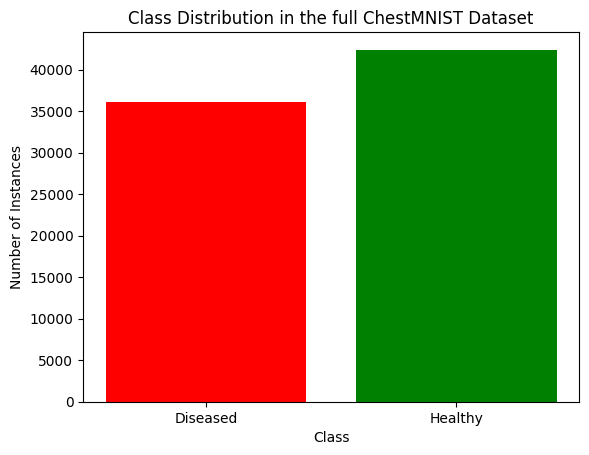

In [8]:
#This is for the whole dataset
all_labels = train_dataset_chest_full.labels
binary_targets = (all_labels.sum(axis=1) > 0).astype(float)

num_positive = binary_targets.sum()

total_instances = binary_targets.size

positive_rate = num_positive / total_instances

print("Positive rate: ", positive_rate)

# Count the instances of each class
num_diseased = num_positive
num_healthy = total_instances - num_positive

# Class distribution
classes = ['Diseased', 'Healthy']
counts = [num_diseased, num_healthy]

# Create bar chart
plt.bar(classes, counts, color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution in the full ChestMNIST Dataset')
plt.show()

##### given that the positive rate is around 45%, which is not too far away from 50%, that shows that it's not perfectly balanced Data (Moderate imbalance), the accuracy can be a useful metric here (in the binary classification task that only shows Diseased vs Healthy).  But given this slight imbalance considering metrics like F1-score would be very good, and also using precision and recall with the accuracy can give better understanding of the model performance on both classes, especially when one class is more important than the other, in this case, I'd suggest the the classifing and not missing diseased class is more important in this task, so using Recall (Sensitivity) would be very useful here too
#### Recall = TP / (TP + FN)

#### you have to change something about the latent code, to show smth, I really wasn't paying attention here :((

In [10]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True, pneumonia_flag=0)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True, pneumonia_flag=0)

==> Evaluating ...
train


100%|██████████| 5/5 [00:00<00:00, 17.53it/s]
<ipython-input-3-fcf857adb708>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  preds = torch.sigmoid(torch.tensor(preds)).numpy()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.8000	Precision: 0.6896	Recall: 0.8000	F1 Score: 0.7288
test


100%|██████████| 351/351 [00:10<00:00, 34.45it/s]

Accuracy: 0.4843	Precision: 0.3990	Recall: 0.4843	F1 Score: 0.4373



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Latent Space

(22433, 512)


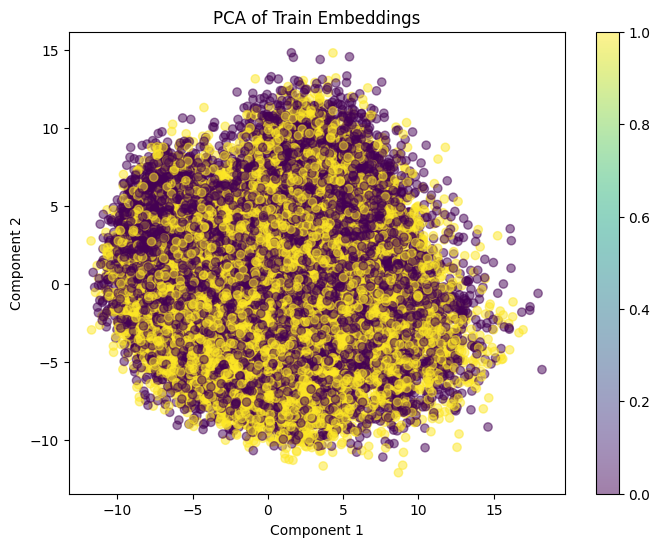

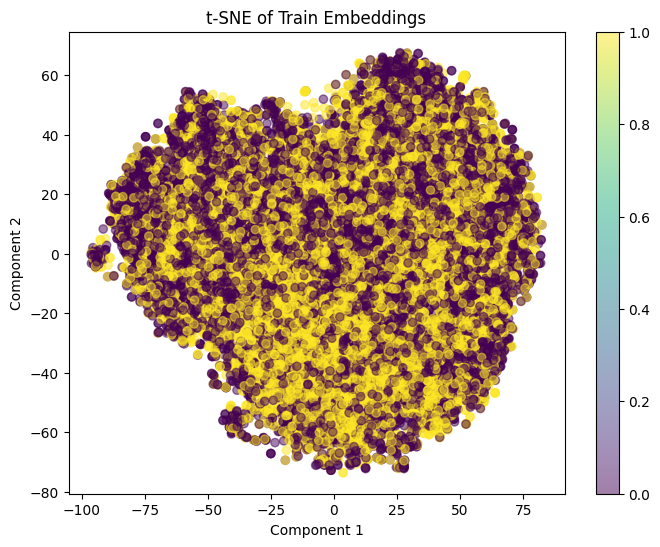

In [11]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False

            embeddings.append(output)
            labels.append(target)

    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels = (test_labels.sum(axis=1) > 0).long()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
print(test_embeddings_flat.shape)
# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu().numpy(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu().numpy(), 't-SNE of Train Embeddings')

## Autoencoder

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Resize
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self, p):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)

criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 9
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Resize the input to match the expected size of the autoencoder
        inputs_resized = F.interpolate(inputs, size=(32, 32), mode='bilinear', align_corners=False)

        # Forward pass
        outputs = model_ae(inputs_resized)
        loss = criterion_ae(outputs, inputs_resized)

        psnr_value = psnr_metric(outputs, inputs_resized)
        ssim_value = ssim_metric(outputs, inputs_resized)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)

        # Resize the input to match the expected size of the autoencoder
        inputs_resized = F.interpolate(inputs, size=(32, 32), mode='bilinear', align_corners=False)

        outputs = model_ae(inputs_resized)

        loss = criterion_ae(outputs, inputs_resized)
        psnr_value_test = psnr_metric(outputs, inputs_resized)
        ssim_value_test = ssim_metric(outputs, inputs_resized)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')

Epoch [1/9], Loss: 0.1556, PSNR: 13.8107, SSIM: 0.1737
Epoch [2/9], Loss: 0.1524, PSNR: 14.0894, SSIM: 0.2493
Epoch [3/9], Loss: 0.1360, PSNR: 14.5067, SSIM: 0.3019
Epoch [4/9], Loss: 0.1306, PSNR: 14.6820, SSIM: 0.3296
Epoch [5/9], Loss: 0.1377, PSNR: 14.4258, SSIM: 0.3528
Epoch [6/9], Loss: 0.1284, PSNR: 14.7284, SSIM: 0.3808
Epoch [7/9], Loss: 0.1193, PSNR: 14.9405, SSIM: 0.3727
Epoch [8/9], Loss: 0.1213, PSNR: 14.8974, SSIM: 0.3722
Epoch [9/9], Loss: 0.1307, PSNR: 14.6443, SSIM: 0.3366
Average Test Loss: 0.0020, Average PSNR: 14.9370, Average SSIM: 0.3756


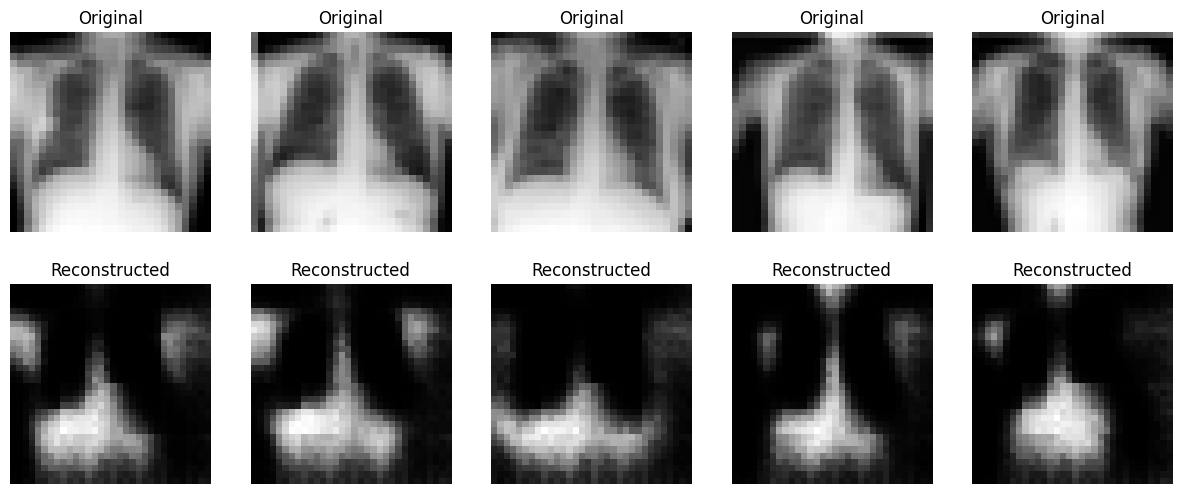

In [13]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# TODO: Function to plot input and output images
def plot_images(model, test_loader, device, num_images=5):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images.to(device)
    outputs = model(images).detach()  # Detach the output from the computation graph
    images = images.cpu()
    outputs = outputs.cpu()

    fig, ax = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for i in range(num_images):
        ax[0, i].imshow(images[i].squeeze(), cmap='gray')
        ax[0, i].set_title('Original')
        ax[0, i].axis('off')

        ax[1, i].imshow(outputs[i].squeeze(), cmap='gray')
        ax[1, i].set_title('Reconstructed')
        ax[1, i].axis('off')
    plt.show()

plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [14]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model
for i in range(0, 10, 3):
    model_transfer.layer1[i].weight.data = model_ae.encoder[i].weight.data
    model_transfer.layer1[i].bias.data = model_ae.encoder[i].bias.data

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device,pneumonia_flag=0)

100%|██████████| 5/5 [00:00<00:00, 57.41it/s]


Epoch: 1	Loss: 0.7160


100%|██████████| 5/5 [00:00<00:00, 55.52it/s]


Epoch: 2	Loss: 0.6559


100%|██████████| 5/5 [00:00<00:00, 48.13it/s]


Epoch: 3	Loss: 0.6431


100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Epoch: 4	Loss: 0.6036


100%|██████████| 5/5 [00:00<00:00, 43.85it/s]


Epoch: 5	Loss: 0.6034


100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Epoch: 6	Loss: 0.5982


100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Epoch: 7	Loss: 0.5782


100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Epoch: 8	Loss: 0.5705


100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Epoch: 9	Loss: 0.5643


100%|██████████| 5/5 [00:00<00:00, 73.24it/s]


Epoch: 10	Loss: 0.5537


100%|██████████| 5/5 [00:00<00:00, 75.69it/s]


Epoch: 11	Loss: 0.5483


100%|██████████| 5/5 [00:00<00:00, 72.59it/s]


Epoch: 12	Loss: 0.5390


100%|██████████| 5/5 [00:00<00:00, 73.35it/s]


Epoch: 13	Loss: 0.5429


100%|██████████| 5/5 [00:00<00:00, 73.97it/s]


Epoch: 14	Loss: 0.5279


100%|██████████| 5/5 [00:00<00:00, 73.93it/s]


Epoch: 15	Loss: 0.5206


100%|██████████| 5/5 [00:00<00:00, 70.86it/s]


Epoch: 16	Loss: 0.5092


100%|██████████| 5/5 [00:00<00:00, 57.53it/s]


Epoch: 17	Loss: 0.5125


100%|██████████| 5/5 [00:00<00:00, 73.65it/s]


Epoch: 18	Loss: 0.4977


100%|██████████| 5/5 [00:00<00:00, 70.79it/s]


Epoch: 19	Loss: 0.4862


100%|██████████| 5/5 [00:00<00:00, 71.61it/s]

Epoch: 20	Loss: 0.4790


In [15]:
print('==> Evaluating ...')
print('train')
test(model_transfer, train_loader_chest, device, convert_to_binary=True,pneumonia_flag=0)
print('test')
test(model_transfer, test_loader_chest, device, convert_to_binary=True,pneumonia_flag=0)

==> Evaluating ...
train


100%|██████████| 5/5 [00:00<00:00, 84.83it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6367	Precision: 0.5451	Recall: 0.6367	F1 Score: 0.5815
test


100%|██████████| 351/351 [00:04<00:00, 72.78it/s]


Accuracy: 0.4948	Precision: 0.4088	Recall: 0.4948	F1 Score: 0.4473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Pneumonia

In [20]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [21]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)
model_pneumonia.extract_embeddings = False

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [26]:
# train
model_pneumonia = train2(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=15, device=device)

100%|██████████| 74/74 [00:01<00:00, 69.42it/s]


Epoch: 1	Loss: 0.0904


100%|██████████| 74/74 [00:01<00:00, 70.24it/s]


Epoch: 2	Loss: 0.0752


100%|██████████| 74/74 [00:01<00:00, 69.75it/s]


Epoch: 3	Loss: 0.0616


100%|██████████| 74/74 [00:01<00:00, 70.58it/s]


Epoch: 4	Loss: 0.0558


100%|██████████| 74/74 [00:01<00:00, 69.11it/s]


Epoch: 5	Loss: 0.0450


100%|██████████| 74/74 [00:01<00:00, 70.28it/s]


Epoch: 6	Loss: 0.0397


100%|██████████| 74/74 [00:01<00:00, 65.83it/s]


Epoch: 7	Loss: 0.0326


100%|██████████| 74/74 [00:01<00:00, 56.20it/s]


Epoch: 8	Loss: 0.0281


100%|██████████| 74/74 [00:01<00:00, 51.80it/s]


Epoch: 9	Loss: 0.0236


100%|██████████| 74/74 [00:01<00:00, 57.21it/s]


Epoch: 10	Loss: 0.0222


100%|██████████| 74/74 [00:01<00:00, 70.75it/s]


Epoch: 11	Loss: 0.0175


100%|██████████| 74/74 [00:01<00:00, 68.66it/s]


Epoch: 12	Loss: 0.0162


100%|██████████| 74/74 [00:01<00:00, 69.94it/s]


Epoch: 13	Loss: 0.0138


100%|██████████| 74/74 [00:01<00:00, 67.73it/s]


Epoch: 14	Loss: 0.0119


100%|██████████| 74/74 [00:01<00:00, 70.50it/s]

Epoch: 15	Loss: 0.0105


In [27]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False,pneumonia_flag=1)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False, pneumonia_flag=1)

==> Evaluating ...
train


100%|██████████| 74/74 [00:00<00:00, 79.30it/s]


Accuracy: 1.0000	Precision: 1.0000	Recall: 1.0000	F1 Score: 1.0000
test


100%|██████████| 10/10 [00:00<00:00, 78.89it/s]

Accuracy: 0.8606	Precision: 0.8827	Recall: 0.8606	F1 Score: 0.8523


## Transfer learning

In [28]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
model_chest_full.extract_embeddings = False

optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train ## we're gonna train on the task on the binary classification on the whole dataset, then transfer that to the pnemonia and checkout
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device,pneumonia_flag=0)

100%|██████████| 307/307 [00:15<00:00, 19.50it/s]


Epoch: 1	Loss: 0.6512


100%|██████████| 307/307 [00:16<00:00, 18.60it/s]


Epoch: 2	Loss: 0.6302


100%|██████████| 307/307 [00:15<00:00, 19.83it/s]


Epoch: 3	Loss: 0.6228


100%|██████████| 307/307 [00:15<00:00, 19.43it/s]


Epoch: 4	Loss: 0.6174


100%|██████████| 307/307 [00:15<00:00, 19.65it/s]


Epoch: 5	Loss: 0.6120


100%|██████████| 307/307 [00:15<00:00, 19.41it/s]


Epoch: 6	Loss: 0.6073


100%|██████████| 307/307 [00:17<00:00, 17.26it/s]


Epoch: 7	Loss: 0.6029


100%|██████████| 307/307 [00:15<00:00, 20.02it/s]


Epoch: 8	Loss: 0.5984


100%|██████████| 307/307 [00:15<00:00, 20.15it/s]


Epoch: 9	Loss: 0.5935


100%|██████████| 307/307 [00:15<00:00, 19.74it/s]


Epoch: 10	Loss: 0.5889


100%|██████████| 307/307 [00:15<00:00, 19.37it/s]


Epoch: 11	Loss: 0.5836


100%|██████████| 307/307 [00:15<00:00, 19.29it/s]


Epoch: 12	Loss: 0.5782


100%|██████████| 307/307 [00:15<00:00, 19.70it/s]


Epoch: 13	Loss: 0.5737


100%|██████████| 307/307 [00:15<00:00, 19.74it/s]


Epoch: 14	Loss: 0.5680


100%|██████████| 307/307 [00:15<00:00, 20.25it/s]


Epoch: 15	Loss: 0.5623


100%|██████████| 307/307 [00:15<00:00, 19.25it/s]


Epoch: 16	Loss: 0.5553


100%|██████████| 307/307 [00:15<00:00, 19.54it/s]


Epoch: 17	Loss: 0.5502


100%|██████████| 307/307 [00:15<00:00, 19.38it/s]


Epoch: 18	Loss: 0.5454


100%|██████████| 307/307 [00:15<00:00, 20.06it/s]


Epoch: 19	Loss: 0.5370


100%|██████████| 307/307 [00:15<00:00, 19.64it/s]

Epoch: 20	Loss: 0.5318


### Transfer learning - Frozen

In [29]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)
model_pneumonia_transfer_frozen.extract_embeddings = False

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model
for i in range(0, 10, 3):
    model_pneumonia_transfer_frozen.layer1[i].weight.data = model_chest_full.layer1[i].weight.data
    model_pneumonia_transfer_frozen.layer1[i].bias.data = model_chest_full.layer1[i].bias.data


# TODO: Freeze all layers except the FC
for param in model_pneumonia_transfer_frozen.layer1.parameters():
    param.requires_grad = False

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [30]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=15, device=device,pneumonia_flag=1)

100%|██████████| 74/74 [00:01<00:00, 55.83it/s]


Epoch: 1	Loss: 0.3208


100%|██████████| 74/74 [00:01<00:00, 53.82it/s]


Epoch: 2	Loss: 0.1832


100%|██████████| 74/74 [00:01<00:00, 66.71it/s]


Epoch: 3	Loss: 0.1614


100%|██████████| 74/74 [00:01<00:00, 66.85it/s]


Epoch: 4	Loss: 0.1499


100%|██████████| 74/74 [00:02<00:00, 29.83it/s]


Epoch: 5	Loss: 0.1431


100%|██████████| 74/74 [00:00<00:00, 75.71it/s]


Epoch: 6	Loss: 0.1376


100%|██████████| 74/74 [00:00<00:00, 75.51it/s]


Epoch: 7	Loss: 0.1340


100%|██████████| 74/74 [00:01<00:00, 73.73it/s]


Epoch: 8	Loss: 0.1288


100%|██████████| 74/74 [00:01<00:00, 73.12it/s]


Epoch: 9	Loss: 0.1262


100%|██████████| 74/74 [00:00<00:00, 75.97it/s]


Epoch: 10	Loss: 0.1221


100%|██████████| 74/74 [00:01<00:00, 65.40it/s]


Epoch: 11	Loss: 0.1187


100%|██████████| 74/74 [00:01<00:00, 54.89it/s]


Epoch: 12	Loss: 0.1161


100%|██████████| 74/74 [00:01<00:00, 54.83it/s]


Epoch: 13	Loss: 0.1170


100%|██████████| 74/74 [00:01<00:00, 73.30it/s]


Epoch: 14	Loss: 0.1133


100%|██████████| 74/74 [00:00<00:00, 76.51it/s]

Epoch: 15	Loss: 0.1138


In [31]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False,pneumonia_flag=1)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False,pneumonia_flag=1)

==> Evaluating ...
train


100%|██████████| 74/74 [00:00<00:00, 78.20it/s]


Accuracy: 0.9584	Precision: 0.9581	Recall: 0.9584	F1 Score: 0.9582
test


100%|██████████| 10/10 [00:00<00:00, 86.70it/s]

Accuracy: 0.8109	Precision: 0.8375	Recall: 0.8109	F1 Score: 0.7955


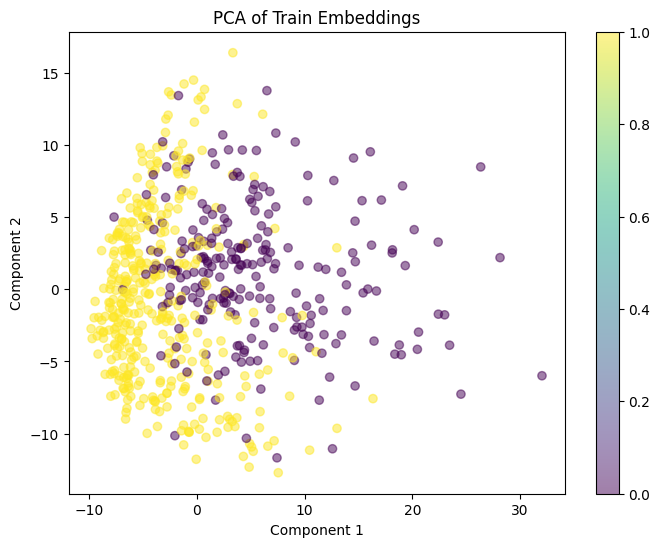

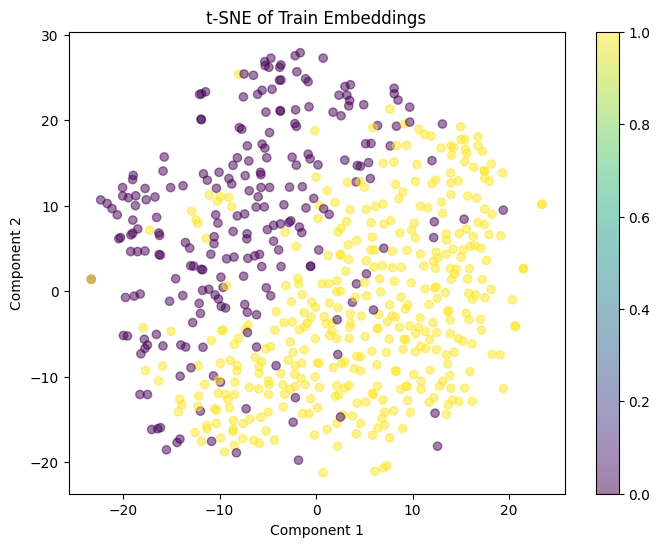

In [32]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [33]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)
model_pneumonia_transfer_trainable.extract_embeddings = False

# TODO: Transfer the weights from the chest model to the pneumonia model
for i in range(0, 10, 3):
    model_pneumonia_transfer_trainable.layer1[i].weight.data = model_chest_full.layer1[i].weight.data
    model_pneumonia_transfer_trainable.layer1[i].bias.data = model_chest_full.layer1[i].bias.data

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [34]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=15, device=device,pneumonia_flag=1)

100%|██████████| 74/74 [00:01<00:00, 67.81it/s]


Epoch: 1	Loss: 0.2331


100%|██████████| 74/74 [00:01<00:00, 55.74it/s]


Epoch: 2	Loss: 0.1153


100%|██████████| 74/74 [00:01<00:00, 51.46it/s]


Epoch: 3	Loss: 0.0926


100%|██████████| 74/74 [00:01<00:00, 57.41it/s]


Epoch: 4	Loss: 0.0755


100%|██████████| 74/74 [00:01<00:00, 71.00it/s]


Epoch: 5	Loss: 0.0627


100%|██████████| 74/74 [00:01<00:00, 72.22it/s]


Epoch: 6	Loss: 0.0549


100%|██████████| 74/74 [00:01<00:00, 71.74it/s]


Epoch: 7	Loss: 0.0449


100%|██████████| 74/74 [00:01<00:00, 71.81it/s]


Epoch: 8	Loss: 0.0383


100%|██████████| 74/74 [00:01<00:00, 69.74it/s]


Epoch: 9	Loss: 0.0334


100%|██████████| 74/74 [00:01<00:00, 71.64it/s]


Epoch: 10	Loss: 0.0278


100%|██████████| 74/74 [00:01<00:00, 70.19it/s]


Epoch: 11	Loss: 0.0233


100%|██████████| 74/74 [00:01<00:00, 70.19it/s]


Epoch: 12	Loss: 0.0204


100%|██████████| 74/74 [00:01<00:00, 66.04it/s]


Epoch: 13	Loss: 0.0188


100%|██████████| 74/74 [00:01<00:00, 52.25it/s]


Epoch: 14	Loss: 0.0163


100%|██████████| 74/74 [00:01<00:00, 51.34it/s]

Epoch: 15	Loss: 0.0140


In [35]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False,pneumonia_flag=1)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False,pneumonia_flag=1)

==> Evaluating ...
train


100%|██████████| 74/74 [00:00<00:00, 81.13it/s]


Accuracy: 0.9998	Precision: 0.9998	Recall: 0.9998	F1 Score: 0.9998
test


100%|██████████| 10/10 [00:00<00:00, 84.60it/s]

Accuracy: 0.8574	Precision: 0.8821	Recall: 0.8574	F1 Score: 0.8482


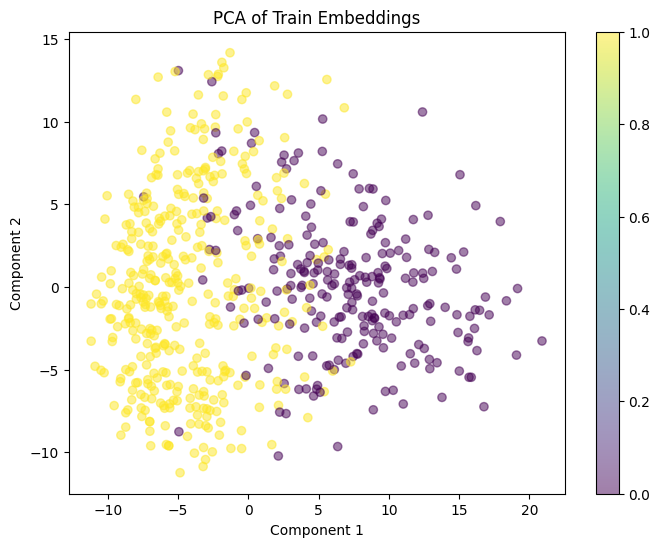

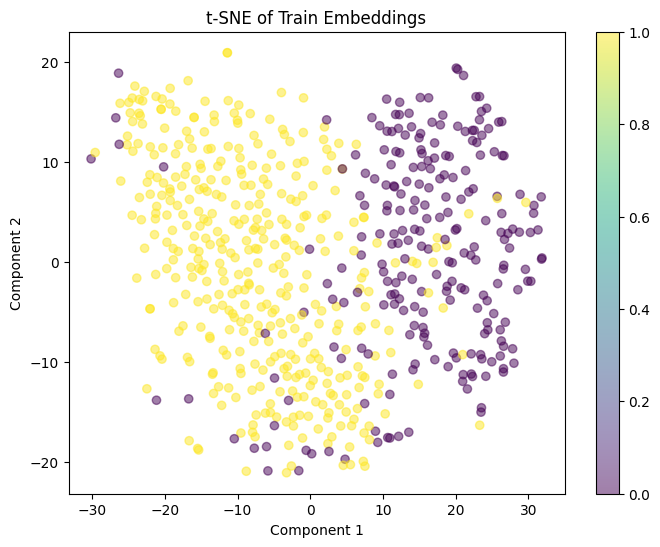

In [37]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(test_embeddings_flat)

# TODO: Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')
